<a href="https://colab.research.google.com/github/hab5510/finrl_feat/blob/main/Sentiment_analysis_FinRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.py">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version**



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
!pip install numpy==1.26.4 --force-reinstall


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.8.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


In [ ]:
# Upgrade pip to avoid version resolution issues
!pip install --upgrade pip

# Install compatible PyTorch, torchvision, torchaudio (CPU for Colab stability)
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --extra-index-url https://download.pytorch.org/whl/cpu


!pip install -q stable-baselines3==2.2.1 sb3-contrib==2.2.1 gymnasium==1.0.0
!pip install -q git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
ERROR: Cannot install gymnasium==1.0.0 and stable-baselines3==2.2.1 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done



<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
!pip install pandas_market_calendars

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.11/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.11/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [ ]:
TRAIN_START_DATE = '2020-01-01'
TRAIN_END_DATE = '2023-01-01'
TRADE_START_DATE = '2023-01-01'
TRADE_END_DATE = '2023-12-31'


In [ ]:
top10_tickers = ['AAPL','MSFT','AMZN','GOOGL','META',
                 'NVDA','JPM','TSLA','BA','DIS']

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = top10_tickers).fetch_data()

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (10060, 8)


In [ ]:
df.shape

(10060, 8)

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2020-01-02,72.620865,72.681312,71.373241,71.627115,135480400,AAPL,3
1,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000,AMZN,3
2,2020-01-02,331.348572,331.378393,325.761816,326.606765,4544400,BA,3
3,2020-01-02,145.769913,145.769913,142.720753,142.907625,9502100,DIS,3
4,2020-01-02,68.026024,68.026024,66.923141,67.018569,27278000,GOOGL,3


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)


Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (1005, 8)
Successfully added vix
Successfully added turbulence index


## Adding Sentiment Analysis Score

In [ ]:
import pandas as pd

# Quickly inspect only the first line (header) – no memory problems
with open("fnspid_news.csv", "r") as f:
    header = f.readline().strip().split(",")
print("CSV columns:", header[:20])    # show first 20 column names


In [ ]:
import pandas as pd

FILE       = "fnspid_news.csv"
COLS       = ["Date", "Article_title", "Stock_symbol"]
TOP10      = set(['AAPL','MSFT','AMZN','GOOGL','META',
                  'NVDA','JPM','TSLA','BA','DIS'])
DATE_MIN   = "2020-01-01"
DATE_MAX   = "2023-12-31"

chunksize  = 250_000

keep_rows  = []             # list of filtered chunks

for i,chunk in enumerate(pd.read_csv(FILE,
                                     usecols=COLS,
                                     chunksize=chunksize,
                                     dtype={"Stock_symbol":"category"},
                                     engine="c",
                                     low_memory=True)):
    # fast date filter (string compare is OK before to_datetime)
    mask_date   = (chunk["Date"] >= DATE_MIN) & (chunk["Date"] <= DATE_MAX)
    mask_ticker = chunk["Stock_symbol"].isin(TOP10)
    sub         = chunk.loc[mask_date & mask_ticker, COLS]
    if not sub.empty:
        keep_rows.append(sub)
    print(f"✓ processed chunk {i+1}, kept {len(sub)} rows")

# concatenate all kept pieces
df_news = pd.concat(keep_rows, ignore_index=True)

# rename & convert date
df_news = df_news.rename(columns={
    "Date": "date",
    "Article_title": "headline",
    "Stock_symbol": "ticker"
})
df_news["date"] = pd.to_datetime(df_news["date"])

print("Final shape:", df_news.shape)
df_news.head()


In [ ]:
import torch, time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd

# Load FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model     = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
model.eval()

def classify_headlines(texts, batch_size=8, log_every=500):
    results, t0 = [], time.time()
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encodings = tokenizer(batch, padding=True, truncation=True,
                              max_length=48, return_tensors="pt")
        with torch.no_grad():
            logits = model(**encodings).logits
        preds = torch.argmax(logits, dim=1).tolist()
        results.extend({0:-1, 1:0, 2:1}[p] for p in preds)
        if i % log_every == 0 and i > 0:
            print(f"{i}/{len(texts)} processed ({time.time()-t0:.1f}s)")
    return results


In [ ]:
df_news.head()

In [ ]:
df_news["score"] = classify_headlines(df_news["headline"].tolist())


In [ ]:
df_news.to_csv("scored_news.csv", index=False)       #  saves 56 k rows with sentiment


In [ ]:
df_news = pd.read_csv("scored_news.csv")


In [ ]:
daily_sent = (df_news[["date","ticker","score"]]
              .groupby(["date","ticker"]).mean().reset_index()
              .rename(columns={"score":"sentiment_score"}))
daily_sent.to_csv("daily_sentiment.csv", index=False)    # tiny (~10 k rows)


In [ ]:
daily_sent = pd.read_csv("daily_sentiment.csv")          # loads in <1 s
# Ensure date strings match format
processed["date"]  = pd.to_datetime(processed["date"]).dt.strftime("%Y-%m-%d")
daily_sent["date"] = pd.to_datetime(daily_sent["date"]).dt.strftime("%Y-%m-%d")

processed = processed.merge(
    daily_sent,
    left_on=["date", "tic"],
    right_on=["date", "ticker"],
    how="left"
)

# Fill NaN sentiment with 0
processed["sentiment_score"] = processed["sentiment_score"].fillna(0)

# Drop the extra 'ticker' column if it exists
if "ticker" in processed.columns:
    processed = processed.drop(columns=["ticker"])


In [ ]:
# 3 ── build processed_full so the RL environment sees every (date, ticker)
list_ticker = processed["tic"].unique().tolist()
list_date   = list(pd.date_range(processed['date'].min(),
                                 processed['date'].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

processed_full = (
    pd.DataFrame(combination, columns=["date", "tic"])
      .merge(processed, on=["date", "tic"], how="left")
)
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date', 'tic'])
processed_full = processed_full.fillna(0)


In [ ]:
processed_full.to_csv("processed_full.csv", index=False)

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [ ]:
INDICATORS = [
    'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
    'close_30_sma', 'close_60_sma', 'sentiment_score', 'vix', 'turbulence'
]

In [ ]:
# Keep only the valid columns

VALID_COLUMNS = ['date', 'tic', 'open', 'high', 'low', 'close', 'volume','day'] + INDICATORS
processed_full = pd.read_csv("processed_full.csv")
processed_full = processed_full[VALID_COLUMNS]
processed_full.dropna(inplace=True)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(20)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,sentiment_score,vix,turbulence
0,2020-01-02,AAPL,71.627092,72.681289,71.373218,72.620842,135480400.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,72.620842,72.620842,0.000000,12.47,0.0
1,2020-01-02,AMZN,93.750000,94.900497,93.207497,94.900497,80580000.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,94.900497,94.900497,0.000000,12.47,0.0
2,2020-01-02,BA,326.606765,331.378393,325.761816,331.348572,4544400.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,331.348572,331.348572,-1.000000,12.47,0.0
3,2020-01-02,DIS,143.517032,146.391525,143.329363,146.391525,9502100.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,146.391525,146.391525,-0.800000,12.47,0.0
4,2020-01-02,GOOGL,67.018569,68.026024,66.923141,68.026024,27278000.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,68.026024,68.026024,-0.666667,12.47,0.0
5,2020-01-02,JPM,119.621142,120.742147,119.167612,120.733582,10803700.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,120.733582,120.733582,-0.250000,12.47,0.0
6,2020-01-02,META,205.621925,208.645331,205.144548,208.635391,12077100.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,208.635391,208.635391,0.000000,12.47,0.0
7,2020-01-02,MSFT,151.289093,153.147093,150.860326,153.042282,22622100.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,153.042282,153.042282,0.000000,12.47,0.0
8,2020-01-02,NVDA,5.942872,5.971746,5.892343,5.971746,237536000.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,5.971746,5.971746,-1.000000,12.47,0.0
9,2020-01-02,TSLA,28.299999,28.713333,28.114000,28.684000,142981500.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,28.684000,28.684000,-0.500000,12.47,0.0


In [ ]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [ ]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

7617
2490


In [ ]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,sentiment_score,vix,turbulence
755,2022-12-30,JPM,124.543618,125.969014,124.196653,125.753334,9292500.0,4.0,0.423462,126.849705,120.917203,57.143990,20.441574,11.345593,124.882475,119.589299,0.000000,21.67,0.766227
755,2022-12-30,META,117.515305,119.762968,117.097591,119.683403,19583800.0,4.0,0.952231,122.984848,111.411239,49.419032,78.427199,9.186714,115.435049,115.697443,0.000000,21.67,0.766227
755,2022-12-30,MSFT,233.466251,235.181401,231.947115,235.044189,21938500.0,4.0,-1.366760,253.270814,227.343642,48.258163,-86.504819,5.313326,240.472864,234.587168,-0.333333,21.67,0.766227
755,2022-12-30,NVDA,14.321271,14.616009,14.220361,14.601023,310490000.0,4.0,-0.309793,18.503090,13.800796,47.045448,-141.558853,13.239276,16.120591,14.735053,0.125000,21.67,0.766227
755,2022-12-30,TSLA,119.949997,124.480003,119.750000,123.180000,157777300.0,4.0,-19.258998,202.513339,99.254662,32.790586,-121.998583,47.953532,161.267667,186.598834,-0.210526,21.67,0.766227


In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,sentiment_score,vix,turbulence
0,2023-01-03,AAPL,128.613978,129.226044,122.582112,123.470604,112117500.0,1.0,-4.648600,147.860275,121.091834,39.011473,-130.963621,35.956352,138.293931,140.567286,-0.448276,22.9,29.954638
0,2023-01-03,AMZN,85.459999,86.959999,84.209999,85.820000,76706000.0,1.0,-3.075118,93.357149,80.929850,41.195599,-71.360174,10.198927,89.424999,97.181000,0.000000,22.9,29.954638
0,2023-01-03,BA,192.949997,197.179993,192.399994,195.389999,8624600.0,1.0,5.326285,196.702727,176.154272,62.905353,141.206999,44.456630,182.859667,166.269167,0.000000,22.9,29.954638
0,2023-01-03,DIS,87.894196,88.872113,86.758227,87.884315,14997100.0,1.0,-2.406148,95.859728,81.780766,44.489021,-57.420591,3.756592,91.139430,94.093272,-0.333333,22.9,29.954638
0,2023-01-03,GOOGL,89.055906,90.507209,87.992285,88.588715,28131200.0,1.0,-2.129973,98.089498,83.452728,43.976971,-67.730627,2.932357,92.974732,93.988818,0.000000,22.9,29.954638


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 10, State Space: 131


In [ ]:

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
import numpy as np

EXPECTED_STATE_DIM = state_space

def force_fixed_state(obs):
    obs = np.asarray(obs, dtype=np.float32).flatten()
    if obs.shape[0] != EXPECTED_STATE_DIM:
        print(f"Auto-fixing bad obs shape {obs.shape[0]} → {EXPECTED_STATE_DIM}")
        if obs.shape[0] < EXPECTED_STATE_DIM:
            # Pad with zeros
            obs = np.pad(obs, (0, EXPECTED_STATE_DIM - obs.shape[0]), mode='constant')
        else:
            # Truncate
            obs = obs[:EXPECTED_STATE_DIM]
    return obs.reshape(1, -1)


class PatchedStockTradingEnv(StockTradingEnv):
    def reset(self, *, seed=None, options=None):
        obs, info = super().reset(seed=seed, options=options)
        obs = force_fixed_state(obs)
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        obs = force_fixed_state(obs)
        return obs, reward, terminated, truncated, info








In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

from stable_baselines3.common.vec_env import DummyVecEnv

env_train = DummyVecEnv([lambda: PatchedStockTradingEnv(df=train, **env_kwargs)])






## Environment for Training



In [ ]:


obs = env_train.reset()
print("obs shape:", obs.shape, "dtype:", obs.dtype)

action = np.zeros(stock_dimension)
obs, reward, done, info = env_train.step(action)
print("step shape:", obs.shape, "dtype:", obs.dtype)


obs shape: (1, 131) dtype: float32
step shape: (1, 131) dtype: float32


/usr/local/lib/python3.11/dist-packages/finrl/meta/env_stock_trading/env_stocktrading.py:328: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]


In [ ]:
obs = env_train.reset()
print("Training reset shape:", obs.shape, obs.dtype)

obs, reward, done, info = env_train.step(np.zeros(stock_dimension))
print("Training step shape:", obs.shape, obs.dtype)



Training reset shape: (1, 131) float32
Training step shape: (1, 131) float32


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")


# set up logger
tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [ ]:
print(repr(env_train.reset()))

array([[ 1.0000000e+06,  7.2620842e+01,  9.4900497e+01,  3.3134857e+02,
         1.4639153e+02,  6.8026024e+01,  1.2073358e+02,  2.0863539e+02,
         1.5304228e+02,  5.9717464e+00,  2.8684000e+01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  7.3266312e+01,
         7.3266312e+01,  7.3266312e+01,  7.3266312e+01,  7.3266312e+01,
         7.3266312e+01,  7.3266312e+01,  7.3266312e+01,  7.3266312e+01,
         7.3266312e+01,  7.1269333e+01,  7.1269333e+01,  7.1269333e+01,
         7.1269333e+01,  7.1269333e+01,  7.1269333e+01,  7.1269333e+01,
         7.1269333e+01,  7.1269333e+01,  7.1269333e+01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.00000

In [ ]:
trained_a2c  = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000)

Auto-fixing bad obs shape 155 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 191 → 131
Auto-fixing bad obs shape 179 → 131
Auto-fixing bad obs shape 359 → 131
Auto-fixing bad obs shape 419 → 131
---------------------------------------
| time/                 |             |
|    fps                | 330         |
|    iterations         | 100         |
|    time_elapsed       | 1           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -14.2       |
|    explained_variance | 0.267       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -6.84       |
|    reward             | 0.05571824  |
|    reward_max         | 0.6823461   |
|    reward_mean        | 0.24315469  |
|    reward_min         | -0.40928033 |
|    std                | 0.997       |
|    value_loss         | 0.406 

### Agent 2: DDPG

### Agent 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

  # set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000)

Auto-fixing bad obs shape 155 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 191 → 131
Auto-fixing bad obs shape 179 → 131
Auto-fixing bad obs shape 359 → 131
Auto-fixing bad obs shape 419 → 131
Auto-fixing bad obs shape 155 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 191 → 131
Auto-fixing bad obs shape 179 → 131
Auto-fixing bad obs shape 359 → 131
Auto-fixing bad obs shape 419 → 131
Auto-fixing bad obs shape 155 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 191 → 131
Auto-fixing bad obs shape 179 → 131
Auto-fixing bad obs shape 359 → 131
Auto-fixing bad obs shape 419 → 131
-------------------------------------
| time/              |              |
|    fps             | 370          |
|    iterations      |

### Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

  # set up logger
tmp_path = RESULTS_DIR + '/td3'
new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000)

Auto-fixing bad obs shape 155 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 191 → 131
Auto-fixing bad obs shape 179 → 131
Auto-fixing bad obs shape 359 → 131
Auto-fixing bad obs shape 419 → 131
Logging Error: 'rollout_buffer'
Auto-fixing bad obs shape 155 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 191 → 131
Auto-fixing bad obs shape 179 → 131
Auto-fixing bad obs shape 359 → 131
Auto-fixing bad obs shape 419 → 131
day: 755, episode: 140
begin_total_asset: 1000000.00
end_total_asset: 208346.47
total_reward: -791653.53
total_cost: 1828.39
total_trades: 3820
Sharpe: -0.048
Logging Error: 'rollout_buffer'
Auto-fixing bad obs shape 155 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 191 → 131
Auto-fixing bad obs s

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

,vix
count,756.000000
mean,24.848664
std,8.759434
min,12.100000
25%,19.367501
50%,23.134999
75%,27.990000
max,82.690002


In [ ]:
insample_risk_indicator.vix.quantile(0.996)

75.40060119628913

In [ ]:
insample_risk_indicator.turbulence.describe()

,turbulence
count,756.000000
mean,7.637635
std,16.377620
min,0.000000
25%,0.000000
50%,4.191969
75%,9.347991
max,293.467726


In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

102.95684474843861

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,sentiment_score,vix,turbulence
0,2023-01-03,AAPL,128.613978,129.226044,122.582112,123.470604,112117500.0,1.0,-4.648600,147.860275,121.091834,39.011473,-130.963621,35.956352,138.293931,140.567286,-0.448276,22.9,29.954638
0,2023-01-03,AMZN,85.459999,86.959999,84.209999,85.820000,76706000.0,1.0,-3.075118,93.357149,80.929850,41.195599,-71.360174,10.198927,89.424999,97.181000,0.000000,22.9,29.954638
0,2023-01-03,BA,192.949997,197.179993,192.399994,195.389999,8624600.0,1.0,5.326285,196.702727,176.154272,62.905353,141.206999,44.456630,182.859667,166.269167,0.000000,22.9,29.954638
0,2023-01-03,DIS,87.894196,88.872113,86.758227,87.884315,14997100.0,1.0,-2.406148,95.859728,81.780766,44.489021,-57.420591,3.756592,91.139430,94.093272,-0.333333,22.9,29.954638
0,2023-01-03,GOOGL,89.055906,90.507209,87.992285,88.588715,28131200.0,1.0,-2.129973,98.089498,83.452728,43.976971,-67.730627,2.932357,92.974732,93.988818,0.000000,22.9,29.954638


In [ ]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value_a2c.shape

(249, 2)

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])

result = pd.merge(df_result_a2c, df_result_ppo, left_index=True, right_index=True, suffixes=('_a2c', '_ppo'))
result = pd.merge(result, df_result_td3, left_index=True, right_index=True,suffixes=('', '_td3'))


df_account_value_a2c.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")
result = pd.merge(result, df_dji, left_index=True, right_index=True, suffixes=('', '_dji'))
result.columns = ['a2c','ppo', 'tdr','dji']
print("result: ", result)
result.to_csv("result.csv")

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (250, 8)
Annual return          0.138579
Cumulative returns     0.137407
Annual volatility      0.114284
Sharpe ratio           1.197347
Calmar ratio           1.536735
Stability              0.375744
Max drawdown          -0.090178
Omega ratio            1.213376
Sortino ratio          1.790631
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.100346
Daily value at risk   -0.013855
dtype: float64
result:                       a2c           ppo           tdr           dji
date                                                              
2023-01-03  1.000000e+06  1.000000e+06  1.000000e+06  1.000000e+06
2023-01-04  1.000773e+06  1.000163e+06  1.002001e+06  1.004026e+06
2023-01-05  9.995372e+05  9.998152e+05  1.001183e+06  9.937744e+05
2023-01-06  1.002705e+06  1.000713e+06  1.007211e+06  1.014915e+06
2023-01-09  1.005771e+06  1.001532e+06  1.008382e+06  1.011506e+06
...              

<Figure size 1500x500 with 0 Axes>

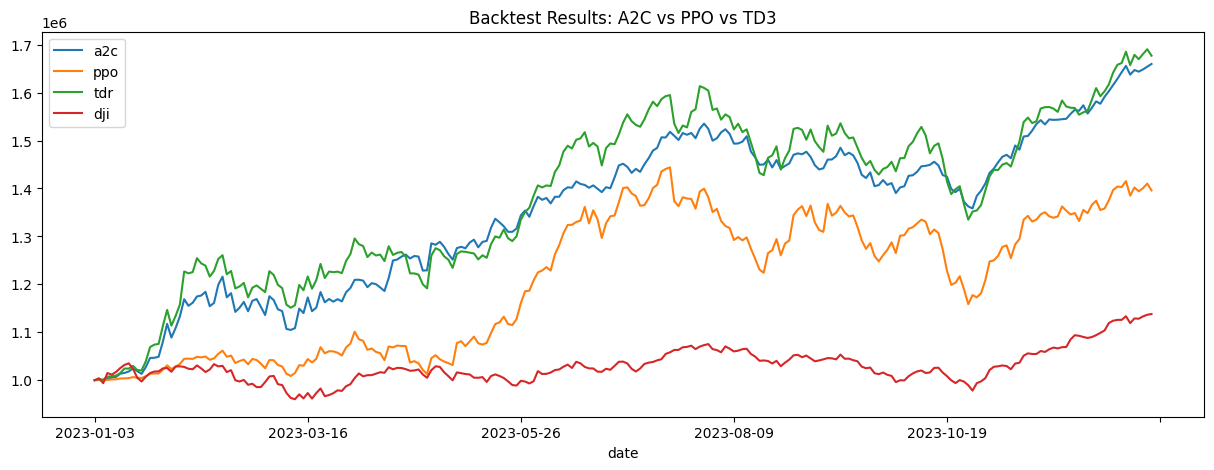

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot(title="Backtest Results: A2C vs PPO vs TD3");